In [1]:
import pandas as pd
import numpy as np
import os
from data_utils import build_pulse, filter_pulse, basic_processing
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statsmodels.iolib.smpickle import load_pickle

In [2]:
# Periods: https://www.census.gov/programs-surveys/household-pulse-survey/datasets.html
week_start = 26
week_end = 45

In [3]:
file_path = f"processed_data/{week_start}_{week_end}_pulse.csv"
if os.path.exists(file_path):
    df = pd.read_csv(file_path)
else:
    df = build_pulse(week_start, week_end)
    df = filter_pulse(df, verbose=True)
    df = basic_processing(df)
    df.to_csv(file_path, index=False)

In [4]:
df[(df["Eligible"] == 1) & (df['Post'] == 1)]["Received_CTC"].value_counts(normalize=True)

1    0.670407
0    0.329593
Name: Received_CTC, dtype: float64

1) Less than $25,000  
2) $25,000 - $34,999  
3) $35,000 - $49,999   
4) $50,000 - $74,999   
5) $75,000 - $99,999   
6) $100,000 - $149,999   
7) $150,000 - $199,999
8) $200,000 and above 

In [113]:
income_threshold = 7
number_of_kids = None
df_m = df.query(f"(Income < {income_threshold})")

In [114]:
df_m[(df_m["Eligible"] == 1) & (df_m['Post'] == 1)]["Received_CTC"].value_counts(normalize=True)

1    0.670407
0    0.329593
Name: Received_CTC, dtype: float64

In [115]:
if number_of_kids:
    df_m = df_m[(df_m['Number_of_kids'] == number_of_kids) | (df_m['Number_of_kids'] == 0)]

In [116]:
df_m[(df_m["Eligible"] == 1) & (df_m['Post'] == 1)]["Received_CTC"].value_counts(normalize=True)

1    0.670407
0    0.329593
Name: Received_CTC, dtype: float64

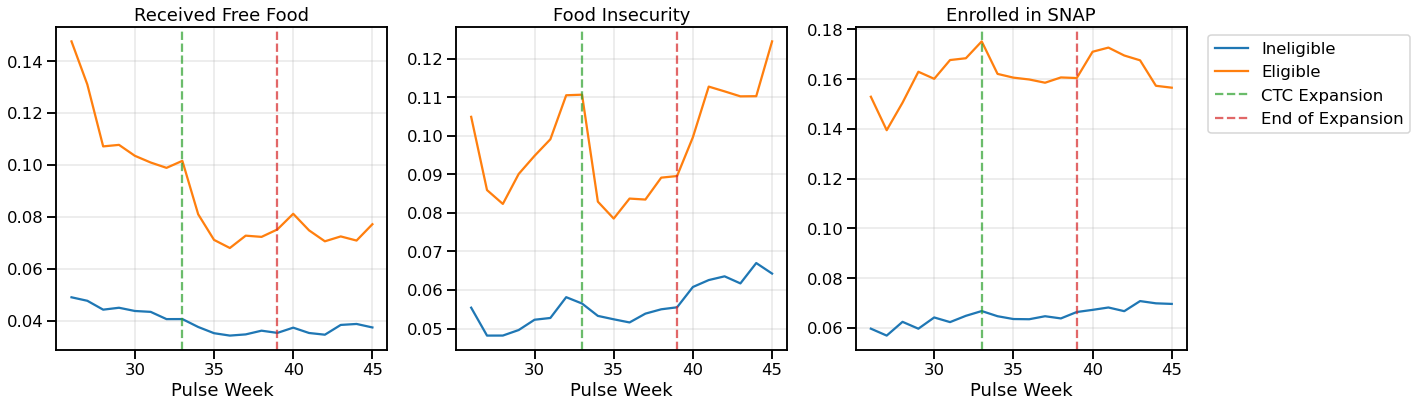

In [117]:
sns.set_context("talk")
fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharex=True)
dependent_vars = ['Received_Free_Food', 'Food_Insecurity', 'Enrolled_in_SNAP']
titles = ['Received Free Food', 'Food Insecurity', 'Enrolled in SNAP']
counter = 0

for j in range(3):
    pivoted_data = df_m.pivot_table(columns="Eligible", index="Week", values=dependent_vars[counter])
    pivoted_data.plot(ax=ax[j], legend=False)
    start = np.where(pivoted_data.index == 33)[0][0]
    stop = np.where(pivoted_data.index == 39)[0][0]
    ax[j].axvline(33, c='tab:green', linestyle="--", alpha=.7)
    ax[j].axvline(39, c='tab:red', linestyle="--", alpha=.7)
    ax[j].set_title(titles[counter])
    ax[j].set_xlabel("Pulse Week")
    ax[j].grid(alpha=.3)
    counter += 1
ax[2].legend(["Ineligible", "Eligible", "CTC Expansion", "End of Expansion"], loc="upper right", bbox_to_anchor=(1.7, 1))
fig.tight_layout();
fig.savefig(f"figures/trendlines_{number_of_kids}_kids_truncated.png", dpi=300, facecolor=fig.get_facecolor())

In [118]:
# sns.set_context("talk")
# fig, ax = plt.subplots(3, 2, figsize=(16, 10), sharex=True)
# dependent_vars = ['Depressed', 'Anxious', 'Received_Free_Food', 'Food_Insecurity', 'Difficulty_with_Expenses', 'Rent_Confidence']
# titles = ['Depressed', 'Anxious', 'Received Free Food', 'Food Insecurity', 'Difficulty_with_Expenses', 'Rent_Confidence']
# counter = 0
# for i in range(3):
#     for j in range(2):
#         pivoted_data = df_m.pivot_table(columns="Eligible", index="Week", values=dependent_vars[counter])
#         pivoted_data.plot(ax=ax[i, j], legend=False)
#         start = np.where(pivoted_data.index == 33)[0][0]
#         stop = np.where(pivoted_data.index == 39)[0][0]
#         ax[i, j].axvline(33, c='tab:green', linestyle="--", alpha=.7)
#         ax[i, j].axvline(39, c='tab:red', linestyle="--", alpha=.7)
#         ax[i, j].set_title(titles[counter])
#         ax[i, j].set_xlabel("Pulse Week")
#         ax[i, j].grid(alpha=.3)
#         counter += 1
# ax[0, 1].legend(["Ineligible", "Eligible", "CTC Expansion", "End of Expansion"], loc="upper right", bbox_to_anchor=(1.6, 1))
# fig.tight_layout();
# fig.savefig(f"figures/trendlines_{number_of_kids}_kids.png", dpi=300, facecolor=fig.get_facecolor())

In [119]:
control_list = ['']
controls = " + ".join(control_list)

In [120]:
dids = []
for var in dependent_vars:
    formula = f"{var} ~  Eligible + Post + {controls} + Treat"
    basic_did = (
        sm.WLS.from_formula(
            formula,
            data=df_m,
            weights=df_m['Household_Weight']
        ).fit(cov_type="HC1"))
    basic_did.save(f"models/{var}_did_model_{number_of_kids}_kids.p")
    dids.append(basic_did)

In [121]:
pd.read_html(summary_col([*dids], stars=True, regressor_order=["Treat"], drop_omitted=True, info_dict={
             "N": lambda x: (str(int(x.nobs))), "Fixed Effects": lambda x: "None"}).as_html(), header=0, index_col=0)[0]


,Received_Free_Food,Food_Insecurity,Enrolled_in_SNAP
Treat,-0.0183***,-0.0254***,0.0103**
NaN,(0.0033),(0.0037),(0.0046)
R-squared,0.0133,0.0080,0.0368
R-squared Adj.,0.0133,0.0080,0.0368
N,842783,842783,842783
Fixed Effects,None,None,None


In [122]:
fe_dids = []
for var in dependent_vars:
    formula = f"{var} ~  Eligible + C(Week) + {controls} + Treat"
    model_path = f"models/{var}_fe_model_{number_of_kids}_kids.p"
    # if os.path.exists(model_path):
    #     print("Loading", var, "locally")
    #     fixed_effects_did = load_pickle(model_path)
    fixed_effects_did = (
        sm.WLS.from_formula(
            formula,
            data=df_m,
            weights=df_m['Household_Weight']
            ).fit(cov_type="HC1"))
    fixed_effects_did.save(model_path)
    fe_dids.append(fixed_effects_did)


## Fixed Effects Results:

In [30]:
summary_col([*fe_dids], stars=True, regressor_order=["Treat"], drop_omitted=True, info_dict = {"N": lambda x: (str(int(x.nobs))), "Fixed Effects": lambda x: "Week/Group"})

,Received_Free_Food,Food_Insecurity,Enrolled_in_SNAP
Treat,-0.0181***,-0.0256***,0.0102**
,(0.0033),(0.0037),(0.0046)
R-squared,0.0145,0.0087,0.0370
R-squared Adj.,0.0145,0.0086,0.0370
N,842783,842783,842783
Fixed Effects,Week/Group,Week/Group,Week/Group


In [31]:
event_studies = []
for var in dependent_vars:
    formula = f"{var} ~ C(Week)*Eligible"
    event_study = (
        sm.WLS.from_formula(
            formula,
            data=df_m,
            weights=df_m['Household_Weight']
            ).fit(cov_type='HC1'))
    event_study.save(f"models/{var}_event_study_{number_of_kids}_kids.p")
    event_studies.append(event_study)

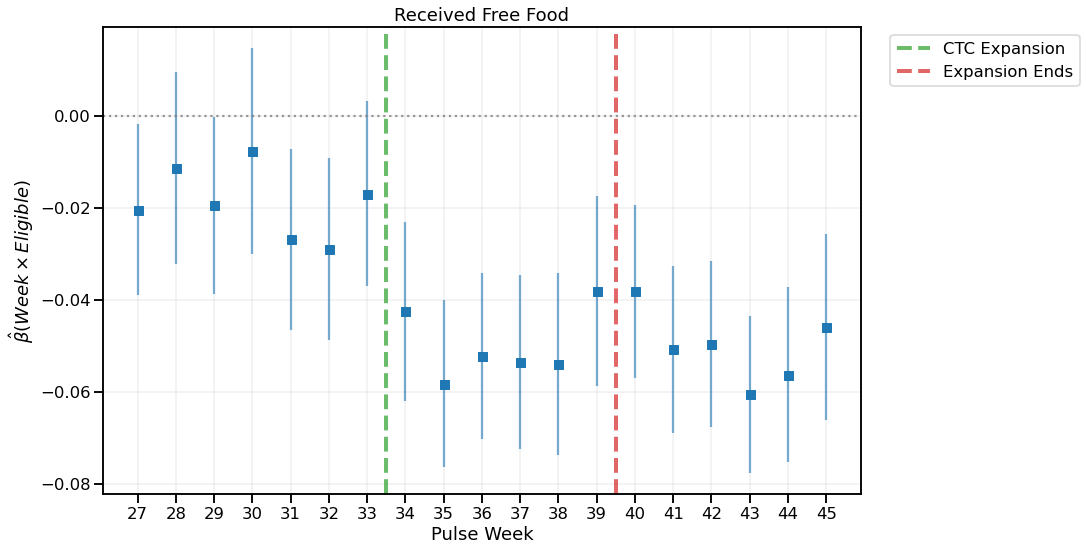

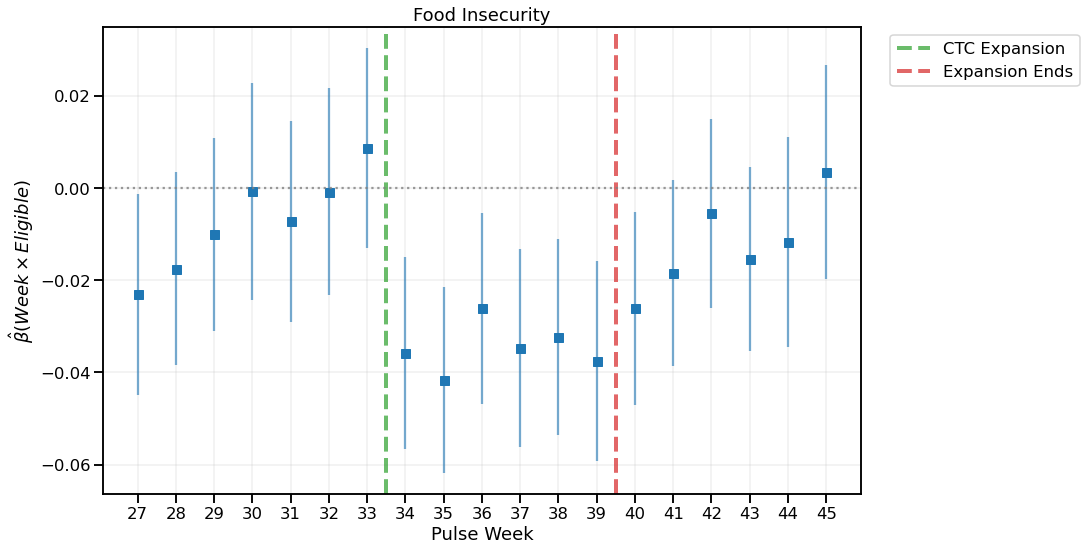

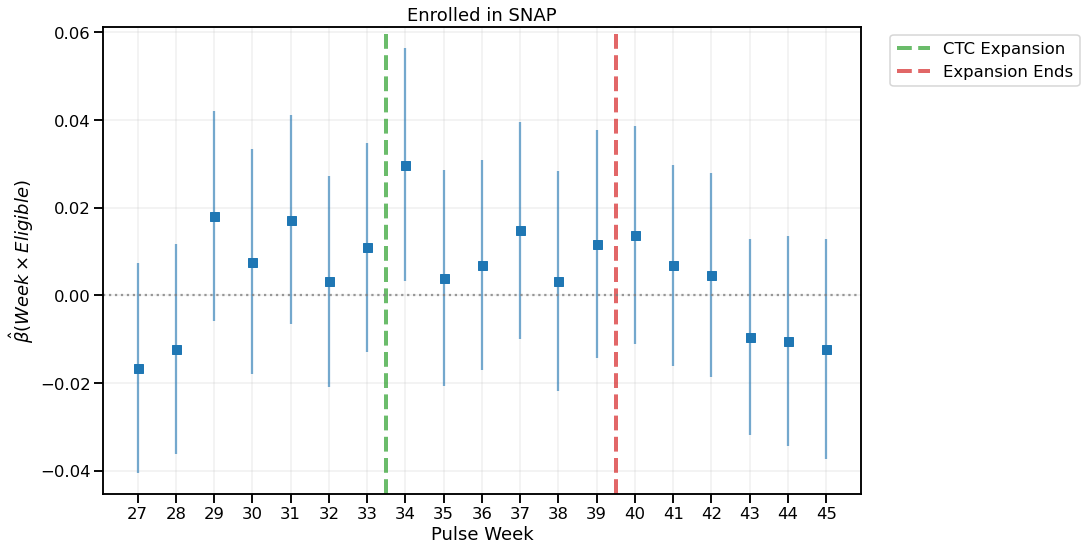

In [32]:
counter=0
for event_study in event_studies:
    estimates = pd.DataFrame({"coef": event_study.params, "std_err":event_study.HC1_se, "low": event_study.conf_int()[0], "high": event_study.conf_int()[1]})
    estimates = estimates.reset_index().rename({"index": "name"}, axis=1)
    did_estimates = estimates[estimates['name'].str.startswith('C(Week)[T.') & estimates['name'].str.endswith('Eligible')]
    did_estimates = did_estimates.reset_index(drop=True)
    did_estimates['Week'] = range(df_m['Week'].astype(int).min()+1, df_m['Week'].astype(int).max()+1)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.axvline(np.where(did_estimates['Week'] == 33)[0][0]+.5, c="tab:green", alpha=.7, linestyle="--", linewidth=4, label="CTC Expansion")
    ax.axvline(np.where(did_estimates['Week'] == 39)[0][0]+.5, c="tab:red", alpha=.7, linestyle="--", linewidth=4, label="Expansion Ends")
    ax.errorbar(did_estimates.index, did_estimates['coef'], yerr=did_estimates['high']-did_estimates['coef'], alpha=.6, c="tab:blue", fmt='none')
    ax.plot(did_estimates['coef'], "s")
    # ax.plot(did_estimates['low'], "s", c="tab:blue")
    # ax.plot(did_estimates['high'], "s", c="tab:blue")
    ax.axhline(0, c="grey", alpha=.8, linestyle=":")
    ax.grid(alpha=.2)
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1))

    ax.set_xlabel("Pulse Week")
    ax.set_ylabel(r"$\hat{\beta} (Week \times Eligible)$")
    ax.set_title(titles[counter])

    ax.set_xticks(did_estimates.index, did_estimates['Week'])

    fig.tight_layout()
    fig.savefig(f"figures/Event_study_{titles[counter]}_{number_of_kids}_kids.png", dpi=300)
    counter+=1


In [16]:
# Received_Free_Food_fe_model_1_kids
# for var in 

# To Do
Add energy bills